In [78]:
# Step1: 根据已有数据创建神经网络ANN
'''
conda create -n myenv python=3.8
conda activate myenv

conda install numpy pandas scikit-learn
conda install -c conda-forge tensorflow
'''
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model

In [79]:
# train the model on the Clark-Y airfoil database 
# Reynolds: 1000-1000000, Mach: 0.1-0.7, and AOA: -3-15 degrees

# Load the data
df = pd.read_csv(r'E:\airfoil_tools\airfoil_ann\input\clark-y-3.csv')

# Filter the data
filtered_df = df[
    (df['Reynold'] >= 0.1e4) & (df['Reynold'] <= 10e5) &  # 雷诺数范围
    (df['Mach'] >= 0.1) & (df['Mach'] <= 0.7) &            # 马赫数范围
    (df['Alpha'] >= -3) & (df['Alpha'] <= 15)              # 迎角范围
]

# Split the data into inputs (X) and outputs (y)
X = filtered_df[['Reynold', 'Mach', 'Alpha']].values
y = filtered_df[['cl', 'cd', 'cm']].values

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [81]:

# Normalize the input data
scaler = MinMaxScaler()
scalery = MinMaxScaler()

scaler = MaxAbsScaler()     # different scaler cause different results, MaxAbsScaler seems to work better
scalery = MaxAbsScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = scalery.fit_transform(y_train)
y_test = scalery.transform(y_test)

# Define the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(128, activation='sigmoid'),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dense(32, activation='sigmoid'),
    tf.keras.layers.Dense(16, activation='sigmoid'),
    tf.keras.layers.Dense(8, activation='sigmoid'),
    tf.keras.layers.Dense(3, activation='linear')
])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# Train the model
history = model.fit(X_train, y_train, epochs=1000, validation_data=(X_test,y_test), callbacks=[early_stop])

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Loss: {loss}, MAE: {mae}")

# MaxAbsScaler Loss: 0.00014633519458584487, MAE: 0.007368187885731459

# R2-score
y_pred = model.predict(X_test)
y_pred = scalery.inverse_transform(y_pred)
y_test = scalery.inverse_transform(y_test)
r2_scores = [r2_score(y_test[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]
for i, r2 in enumerate(r2_scores):
    print(f"R² score for output {i+1}: {r2}")

Epoch 1/1000
240/240 [==============================] - 2s 5ms/step - loss: 0.0414 - mae: 0.1640 - val_loss: 0.0315 - val_mae: 0.1445
Epoch 2/1000
240/240 [==============================] - 1s 3ms/step - loss: 0.0216 - mae: 0.1121 - val_loss: 0.0146 - val_mae: 0.0875
Epoch 3/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0113 - mae: 0.0753 - val_loss: 0.0091 - val_mae: 0.0685
Epoch 4/1000
240/240 [==============================] - 1s 3ms/step - loss: 0.0072 - mae: 0.0610 - val_loss: 0.0061 - val_mae: 0.0558
Epoch 5/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0051 - mae: 0.0516 - val_loss: 0.0045 - val_mae: 0.0480
Epoch 6/1000
240/240 [==============================] - 1s 3ms/step - loss: 0.0041 - mae: 0.0457 - val_loss: 0.0039 - val_mae: 0.0452
Epoch 7/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0035 - mae: 0.0416 - val_loss: 0.0033 - val_mae: 0.0401
Epoch 8/1000
240/240 [==============================] - 1s 2ms

In [82]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_69 (Dense)            (None, 256)               1024      
                                                                 
 dense_70 (Dense)            (None, 128)               32896     
                                                                 
 dense_71 (Dense)            (None, 64)                8256      
                                                                 
 dense_72 (Dense)            (None, 32)                2080      
                                                                 
 dense_73 (Dense)            (None, 16)                528       
                                                                 
 dense_74 (Dense)            (None, 8)                 136       
                                                                 
 dense_75 (Dense)            (None, 3)               

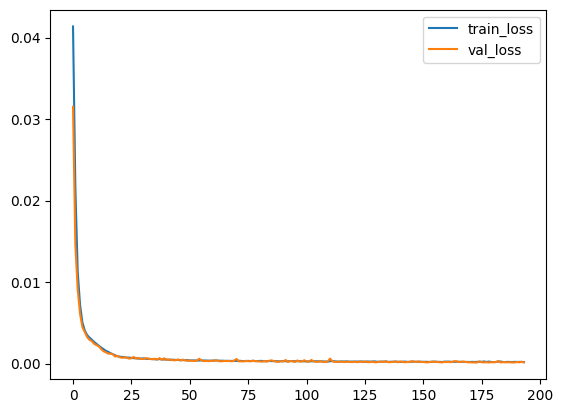

In [83]:
# plot the loss curve
losses = pd.DataFrame(history.history)
plt.plot(losses.index, losses['loss'], label='train_loss')
plt.plot(losses.index, losses['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [84]:
# Save the entire model to a file
model.save('clark-y-cnn-MaxAbsScaler.h5')